# Functional Encryption - Classification and information leakage
 
### Generalizing resistance

We have seen in part 5 that we could provide great resistance against a small feed forward collateral net. But we also know that stronger models have a better ability to extract and exploit information. In particular, the model we protect our learning task against **might not be the one the adversary will use**. Therefore, we are looking for a sabotage which would be efficient for any kind on neural networks.

What we have shown in the `notebooks` section is that there is an almost natural hierarchy relation between networks: more complicated networks (deeper, with larger nayers, or with convolutions) have a better accuracy and have better resistance to sabotage than small networks. In particular, we have seen that protecting against _strong_ models gives automatic protection against _weaker_ models. However, this holds up to a certain point where models get insanely big, and where the size of the model does not help anymore to gain collateral information.

Therefore, protecting against a "big" CNN ("big" here is the official CNN provided in the Pytorch mnist example, which is not big for the Machine Learning Community, but recall that it works on an output of 4 numbers which is re-amplified, so in comparison it is HUGE), should provide good protection on all networks.


In addition, we will also assess resistance against classical models. We have tried almost exhaustively the sklearn library and observe very different performance between the models on the collateral task.

### Setting

To wrap it up, here is the 3 phases game a bit updated:

```
  |
  Q
 / \
C   F
|   |
```

 - The normal phase where both tasks learn and strengthen before the joint optimisation:
  - `Optimize: Q + C`
  - `Optimize: Freezed(Q) + F`
 - The joint optimisation phase where C and F adpat to the Q variations and Q is optimised to reduce the loss `C - alpha * F`:
  - `Optimize: Freezed(Q) + C`
  - `Optimize: Freezed(Q) + F`
  - `Optimize : Q + [Freezed(C) - alpha * Freezed(F)]`
 - **The recovery part, where `Q` doesn't change anymore, but the collateal net F is replaced by a new adversary**:
  - `Optimize: Freezed(Q) + C`
  - `Optimize: Freezed(Q) + NEW F`
  
### Purpose

What we want to achieve here is finding a family on which `Q` offers a good resistance, ie where the accuracy of the collateral model is close to 50%.

In cryptologic terms, what we want to perform actually is a distinguishability task, but we will get back to it at the end of this part.

# 6. Generalized sabotage


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import show_results
# We now import from the collateral module
from learn import collateral

In [3]:
torch.set_num_threads(4)

In [4]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.new_adversary_epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

## 6.1 Building resistance against a CNN

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN.

In [5]:
PRIVATE_OUTPUT_SIZE = 4
N_CHARS = 10
N_FONTS = 2

class CollateralNet(nn.Module):
    def __init__(self):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, PRIVATE_OUTPUT_SIZE, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- Junction
        self.jct = nn.Linear(PRIVATE_OUTPUT_SIZE, 784)

        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)

        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [6]:
def build_resistance(model, alpha=0):
    """
    Perform a dual learning phase with sabotage
    """
    args = Parser()
    # We are just building Q so we don't need the 3rd phase, it will be assessed later!
    args.new_adversary_epochs = 0
    
    train_loader, test_loader = collateral.get_data_loaders(args)

    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + args.new_adversary_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        recover = epoch > args.epochs + args.sabotage_epochs
        if recover:
            print("(recover)")
        collateral.train(
            args, model, train_loader, optimizer, epoch, alpha, 
            initial_phase, perturbate, recover, False
        )
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, False)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [7]:
path = '../data/models/quadconvnet_part6.pt'
model = CollateralNet()
results = {}

try:
    model.load_state_dict(torch.load(path))
    model.eval()
    print('Model loaded!')
except FileNotFoundError:
    print('Computing model...')
    alpha=1.7
    test_perfs_char_perturbate, test_perfs_font_perturbate = build_resistance(model, alpha=alpha)
    results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_perturbate
    results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_perturbate
    
    model.results = results
    # save model
    torch.save(model.state_dict(), path)

Model loaded!


## 6.2 Testing resistance againts multiples nets

We load the `Q` net that we have thoroughly built and it will be given to our new network structure

In [8]:
quadratic_model = model
quadratic_model.freeze('quad')

We now perform only the last phase with the new adversary

In [9]:
def evaluate_resistance(model, alpha=0):
    args = Parser()
    
    train_loader, test_loader = collateral.get_data_loaders(args)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.new_adversary_epochs + 1):
        initial_phase = False
        perturbate = False
        recover = True
        
        new_adversary = True
        
        collateral.train(
            args, model, train_loader, optimizer, epoch, alpha,
            initial_phase, perturbate, recover, new_adversary
        )
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

Here is the basic structure of a network like those seen previously. There is a quadratic part which inherits from the `Q` loaded, and a method `conv_font` is left empty so that we can provide arbitrary adversary by inheriting from this `BaseNet`.

In [10]:
class BaseNet(nn.Module):
    def __init__(self, quadratic_model):
        super(BaseNet, self).__init__()
        self.proj1 = quadratic_model.proj1
        self.diag1 = quadratic_model.diag1
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_font(self, x):
        pass
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [11]:
resistance_reports = {}

### 6.2.1 Fully connected models 

Here we inherit from BaseNet and we only have to specify `conv_font` and declare the layers used.

In [16]:
class FFNet(BaseNet):
    def __init__(self, architecture, quadratic_model):
        super(FFNet, self).__init__(quadratic_model)
        # --- FFNs for font families
        self.architecture = architecture
        n_layer = len(architecture) + 1
        input_size = PRIVATE_OUTPUT_SIZE
        for i_layer, output_size in enumerate(architecture):
            setattr(self, f"net_{i_layer}", nn.Linear(input_size, output_size))
            input_size = output_size
        setattr(self, f"net_{n_layer}", nn.Linear(input_size, N_FONTS)) 
    
    def conv_font(self, x):
        # --- FFN
        architecture = self.architecture
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{n_layer}")  
        x = linear(x)
        return x
        
        


----- [64, 32, 16, 8]
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.750879
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.689744
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.695954
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.695641

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5240/10000 (52.40%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690036
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.685384
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.698005
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.692474

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5145/10000 (51.45%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686558
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.697787
Train Epoch: 3

Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.690514
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.693087
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.693215

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5045/10000 (50.45%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692458
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.689306
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.692752
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.697782

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5090/10000 (50.90%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690697
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.692828
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.690020
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.692479

Test s

Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.702525
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.690259
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.691294

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5161/10000 (51.61%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683271
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.694451
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.680990
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.698583

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5122/10000 (51.22%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695992
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.687571
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.702064
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.690116

Test s

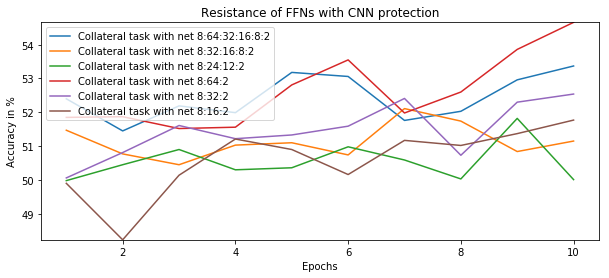

In [17]:
architectures = [[64, 32, 16, 8], [32, 16, 8], [24, 12], [64], [32], [16]]

for architecture in architectures:
    print('\n-----', architecture)
    model = FFNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    architecture = ':'.join(map(str, [8] + architecture + [N_FONTS]))
    resistance_reports[f"Collateral task with net {architecture}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of FFNs with CNN protection")


### 6.2.2 CNN models

In [19]:
class CNNet(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet, self).__init__(quadratic_model)
        # --- CNNs for font families
        self.nn_modules = nn_modules
        setattr(self, "net_0", nn.Linear(PRIVATE_OUTPUT_SIZE, 784))
        for i_layer, nn_module in enumerate(nn_modules):
            setattr(self, f"net_{i_layer + 1}", nn_module)
    
    def conv_font(self, x):
        switched_from_conv_lin = False
        out_channels = []
        # Make the junction
        linear = getattr(self, "net_0")  
        x = linear(x)
        x = x.view(-1, 1, 28, 28)
        # --- CNN
        for i_layer, _ in enumerate(self.nn_modules):
            layer = getattr(self, f"net_{i_layer + 1}")
            if isinstance(layer, nn.Conv2d): # Conv layer
                x = F.relu(layer(x))
                x = F.max_pool2d(x, 2, 2)
                out_channels.append(layer.out_channels)
            else: # Linear layer
                if not switched_from_conv_lin:
                    x = x.view(-1, 4*4*out_channels[-1])
                    switched_from_conv_lin = True
                if i_layer < len(self.nn_modules) - 1:
                    x = F.relu(layer(x))
                else:
                    x = layer(x)
        return x
         

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.490529
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.697758
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.692003
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.692436

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5015/10000 (50.15%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695105
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.687491
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.697187
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.691813

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5029/10000 (50.29%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690532
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.695601
Train Epoch: 3 [38400/60000 (64%)]	Lo

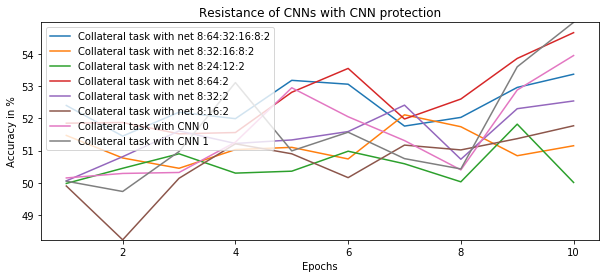

In [20]:
architectures = [
    (
        nn.Conv2d(1, 20, 5, 1),
        nn.Conv2d(20, 50, 5, 1),
        nn.Linear(4*4*50, 500),
        nn.Linear(500, N_FONTS)
    ),
    (
        nn.Conv2d(1, 30, 4, 1),
        nn.Conv2d(30, 100, 4),
        nn.Linear(100 * 4 * 4, 1000),
        nn.Linear(1000, 100),
        nn.Linear(100, N_FONTS)
    )
]
for i, architecture in enumerate(architectures):
    model = CNNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    resistance_reports[f"Collateral task with CNN {i}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of CNNs with CNN protection")

We observe that the accuracy remains reeally low, under 55%, which is very positive. One could argue that leaving more time to the collateral models to train would lead to higher accuracies. This is true but is mitigated by the fact that we can also give more time for building the resistance: as we can and might show, we can keep control of the collateral accuracy even with long attacks scenarios with a sufficiently long resistance phase (around 100 epochs is our setting).

## 6.3 Non-NN models

We now test many models from the sklearn library

### Data preparation

In [21]:
transform = BaseNet(quadratic_model)

In [22]:
def get_input_onehot_labels(dataset, label="font", one_hot=True):
    data_input = dataset.tensors[0]
    label_idx = {'char': 0, 'font': 1}[label]
    label_size = {'char': N_CHARS, 'font': N_FONTS}[label]
    labels = dataset.tensors[1][:, label_idx].view(-1, 1)
    
    data_label_onehot = torch.zeros(len(labels), label_size)
    data_label_onehot.scatter_(1, labels, 1)
    
    return data_input, labels, data_label_onehot
    

Get dataset and transform in one hot vector

In [26]:
train_dataset, test_dataset = collateral.data.get_datasets(None, None)
train_input, train_label, train_label_one_hot = get_input_onehot_labels(train_dataset, label="font")
test_input, test_label, test_label_one_hot = get_input_onehot_labels(test_dataset, label="font")

Training set 60000 items
Testing set  10000 items


Apply the quadratic model transformation

In [27]:
train_input = transform.quad(train_input).detach().numpy()
test_input = transform.quad(test_input).detach().numpy()

In [51]:
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

In [52]:
train_input.shape, train_label.shape

((60000, 4), torch.Size([60000]))

In [53]:
ALL = train_input.shape[0]
CPOWER = 'LOW'

In [54]:
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn import svm

In [55]:
def evaluate_sklearn(reg, one_hot=True, limit=int(10e10)):
    train_labels = {True: train_label_one_hot, False: train_label}[one_hot]
    reg.fit(train_input[:limit], train_labels[:limit].detach().numpy()) 
    output = reg.predict(test_input)
    if one_hot:
        pred = torch.tensor(output).argmax(1, keepdim=True)
    else:
        if isinstance(output, list):
            pred = torch.tensor(list(map(round, output))).long().view(-1, 1)
        else:
            pred = torch.tensor(np.round(output)).long().view(-1, 1)
    y = test_label.view_as(pred)
    acc = pred.eq(y).sum().item() / len(pred)
    return acc

### Linear models

In [56]:
reg = linear_model.Ridge(alpha=.9)
acc = evaluate_sklearn(reg)
print(acc)
resistance_reports['linear model Ridge'] = acc * 100

0.5065


In [57]:
reg = linear_model.RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100], cv=5)
acc = evaluate_sklearn(reg)
print(acc)

0.5065


In [58]:
reg = linear_model.Lasso(alpha=0.1)
acc = evaluate_sklearn(reg)
print(acc)
resistance_reports['linear model Lasso'] = acc * 100

0.5005


In [59]:
reg = linear_model.LassoLars(alpha=0.1)
acc = evaluate_sklearn(reg)
print(acc)

0.5005


In [60]:
reg = linear_model.BayesianRidge()
acc = evaluate_sklearn(reg, one_hot=False)
print(acc)

0.5084


In [61]:
reg = linear_model.LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial', max_iter=1000)
acc = evaluate_sklearn(reg, one_hot=False)
print(acc)
resistance_reports['logistic regression'] = acc * 100

0.5064


In [62]:
reg = linear_model.LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial')
acc = evaluate_sklearn(reg, one_hot=False)
print(acc)

0.5066


### Quadratic Discriminant Analysis

In [63]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [64]:
clf = QuadraticDiscriminantAnalysis()
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Quadratic Discriminant Analysis'] = acc * 100

0.5431


### Kernel Ridge

In [65]:
clf = kernel_ridge.KernelRidge(alpha=1.0)
limit = {'LOW': 15000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=8.11476e-10): result may not be accurate.
  overwrite_a=False)


0.5131


### SVM

In [66]:
clf = svm.SVC(gamma='scale', kernel='linear')
limit = {'LOW': 5000, 'MEDIUM': 15000, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])

print(acc)

0.5005


In [67]:
clf = svm.SVC(gamma='scale', kernel='rbf')
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)
resistance_reports['SVM (rbf)'] = acc * 100

0.5755


In [68]:
clf = svm.SVC(gamma='scale', kernel='poly', coef0=0)
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)

0.5154


In [69]:
clf = svm.SVC(gamma='scale', kernel='sigmoid', coef0=0)
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)

0.4945


### Stochastic gradient Descent

In [70]:
clf = linear_model.SGDClassifier(loss="hinge", penalty="l2")
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['SGDClassifier'] = acc * 100

0.5035


/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [71]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss="log")
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

0.5005


### K-Neighbors Classifier

In [72]:
from sklearn.neighbors import KNeighborsClassifier

In [73]:
clf = KNeighborsClassifier(n_neighbors=7)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['K-Neighbors Classifier'] = acc * 100

0.6605


### Gaussian process (not scalable)

In [74]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [85]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0)
limit = {'LOW': 1700, 'MEDIUM': 5000, 'HIGH': 20000}
acc = evaluate_sklearn(gpc, one_hot=False, limit=limit[CPOWER])
print(acc)
resistance_reports['Gaussian process'] = acc * 100

0.611


### Naive Bayes

In [86]:
from sklearn.naive_bayes import GaussianNB

In [87]:

gnb = GaussianNB()
acc = evaluate_sklearn(gnb, one_hot=False)
print(acc)

0.5426


### Decision Tree Classifier

In [88]:
from sklearn.tree import DecisionTreeClassifier

In [89]:

clf = DecisionTreeClassifier(max_depth=5)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

resistance_reports['Decision Tree Classifier'] = acc * 100

0.5897


### Ensemble methods

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [91]:
clf = RandomForestClassifier(max_depth=30, n_estimators=100, max_features=4)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Random Forest Classifier'] = acc * 100

0.6705


In [92]:
clf = AdaBoostClassifier(n_estimators=200, learning_rate=1.)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['AdaBoost Classifier'] = acc * 100

0.5663


In [93]:
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
    max_depth=10, random_state=0)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Gradient Boosting Classifier'] = acc * 100

0.6447


### (sklearn) Neural Network

In [94]:
from sklearn.neural_network import MLPClassifier

In [95]:
clf = MLPClassifier(solver='lbfgs', alpha=1,
                    hidden_layer_sizes=(10, 40, 10), random_state=1)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

0.5579


## Summary

In [96]:
def print_table(results):
    n_cols = 2
    title_length = 0
    for title in results.keys():
        title_length = max(title_length, len(title))
    result_length = 8
    table_length = 1 + n_cols + title_length + result_length
    sep = '+'.join(
        ['', '-'*title_length, '-'*result_length, '']
    )
    for title, serie in results.items():
        print(sep)
        title = (title + ' '*title_length)[:title_length]
        if isinstance(serie, list):
            result = round(np.mean(serie[-4:]), 2)
        else:
            result = round(serie, 2)
        result = (' ' +str(result) + '%' + ' '*result_length)[:result_length]
        line = '|'.join(
            ['', title, result, '']
        )
        print(line)
    print(sep)

In [97]:
print_table(resistance_reports)

+---------------------------------------+--------+
|Collateral task with net 8:64:32:16:8:2| 52.53% |
+---------------------------------------+--------+
|Collateral task with net 8:32:16:8:2   | 51.46% |
+---------------------------------------+--------+
|Collateral task with net 8:24:12:2     | 50.61% |
+---------------------------------------+--------+
|Collateral task with net 8:64:2        | 53.28% |
+---------------------------------------+--------+
|Collateral task with net 8:32:2        | 52.0%  |
+---------------------------------------+--------+
|Collateral task with net 8:16:2        | 51.33% |
+---------------------------------------+--------+
|Collateral task with CNN 0             | 52.14% |
+---------------------------------------+--------+
|Collateral task with CNN 1             | 52.44% |
+---------------------------------------+--------+
|linear model Ridge                     | 50.65% |
+---------------------------------------+--------+
|linear model Lasso            

### Compative results

+---------------------------------------+--------+
|Collateral task with net 8:64:32:16:8:2| 52.53% |
+---------------------------------------+--------+
|Collateral task with net 8:32:16:8:2   | 51.46% |
+---------------------------------------+--------+
|Collateral task with net 8:24:12:2     | 50.61% |
+---------------------------------------+--------+
|Collateral task with net 8:64:2        | 53.28% |
+---------------------------------------+--------+
|Collateral task with net 8:32:2        | 52.0%  |
+---------------------------------------+--------+
|Collateral task with net 8:16:2        | 51.33% |
+---------------------------------------+--------+
|Collateral task with CNN 0             | 52.14% |
+---------------------------------------+--------+
|Collateral task with CNN 1             | 52.44% |
+---------------------------------------+--------+
|linear model Ridge                     | 50.65% |
+---------------------------------------+--------+
|linear model Lasso                     | 50.05% |
+---------------------------------------+--------+
|logistic regression                    | 50.64% |
+---------------------------------------+--------+
|Quadratic Discriminant Analysis        | 54.31% |
+---------------------------------------+--------+
|SVM (rbf)                              | 57.55% |
+---------------------------------------+--------+
|SGDClassifier                          | 50.35% |
+---------------------------------------+--------+
|K-Neighbors Classifier                 | 66.05% |*
+---------------------------------------+--------+
|Gaussian process                       | 61.1%  |*
+---------------------------------------+--------+
|Decision Tree Classifier               | 58.97% |
+---------------------------------------+--------+
|Random Forest Classifier               | 67.05% |*
+---------------------------------------+--------+
|AdaBoost Classifier                    | 56.63% |
+---------------------------------------+--------+
|Gradient Boosting Classifier           | 64.47% |*
+---------------------------------------+--------+

## Conclusion

Overall, our technique is very successful with neural networks as the accuracy observed never exceeds 55%. More generally, the collateral models which use linear components behave quite poorly which proves our resistance was efficient.

However, those based on completely different learning approaches (like K-Neighbors Classifier or Random Forest Classifier for example) manage to keep a pretty good accuracy in general. They also suffer from substantial accuracy drop in the sabotage setting, but as their initial performance was really good, they stand as outliers and robust adversaries which can help disclosing meaningful and sensitive information. For example, the K-Neighbors Classifier succeeds in its predictions almost 2 times out of 3.

The reason why we are not as efficient with those models is because our method is very simple and is based on linear corrections those sabotaged gradient updates, and Knn for example are not sensitive to those perturbations. They would for instance be far more sensitive to arbitrary noise, but it is not possible to model noise in a small quadratic model such as the one we are using.

### Next step
What we actually want to do is a distinguishability test, where an adversary comes with a letter encrypted in two different fonts. These two images are given to a challenger who choose one and run the private net on it. Depending on the output of the private net which is made public, the adversary should decides which image was used.